# Auxiliary particle filter

Notebook about testing auxiliary particle filter.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

# Add parent directory to sys.path
print(os.getcwd())
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

d:\School\Fakulteta\2. stopnja\2. letnik\Master\notebooks


In [2]:
from src.models.mssv import MSSVModelParams, MSSVModel
from src.filters.smc.auxiliary_pf import AuxiliaryParticleFilter
from src.filters.smc.resampling import systematic_resampling
from src.data_generation.simulate_data import simulate_data

In [3]:
# Set random seed for reproducibility
rng = np.random.default_rng(42)

# True parameters
theta = MSSVModelParams(
    mu=[-1.0, 1.6],
    phi=[0.95, 0.95],
    sigma_eta=[0.1, 0.2],
    P=[[0.95, 0.05],
        [0.05, 0.95]]
)

# Initialize model
model = MSSVModel(rng=rng)

In [4]:
# Simulate data
T = 300
true_states, y = simulate_data(model, theta, T, rng)

In [5]:
# Run particle filter
pf = AuxiliaryParticleFilter(model, n_particles=1000, resampler=systematic_resampling)
history = pf.run(y, theta)

In [6]:
h_true = np.array([h for h, s in true_states])
s_true = np.array([np.nonzero(s)[0][0] for h, s in true_states])

T = len(history)
N = len(history[0][0])
K = len(theta.mu)  # number of regimes

print("Number of time steps:", T)
print("Number of particles:", N)
print("Number of regimes:", K)

Number of time steps: 301
Number of particles: 1000
Number of regimes: 2


In [7]:
from scipy.stats import gaussian_kde

def HDI(values, weights, cred_mass=0.95, gridsize=1000):
    values = np.array(values)
    weights = np.array(weights)
    assert np.isclose(weights.sum(), 1.0)

    # ----- KDE -----
    kde = gaussian_kde(values, weights=weights)
    x_grid = np.linspace(values.min() - 0.2 * (values.max() - values.min()), values.max() + 0.2 * (values.max() - values.min()), gridsize)
    pdf = kde(x_grid)
    pdf /= pdf.sum() * (x_grid[1]-x_grid[0])  # normalize to integrate to 1

    # ----- Determine threshold for HDI -----
    # Sort densities descending
    idx_sort = np.argsort(pdf)[::-1]
    pdf_sorted = pdf[idx_sort]

    cum_prob = 0.0
    included = np.zeros_like(x_grid, dtype=bool)
    threshold = 0.0
    for i, p in enumerate(pdf_sorted):
        # find original index in x_grid
        orig_idx = idx_sort[i]
        included[orig_idx] = True
        cum_prob += p * (x_grid[1]-x_grid[0])
        if cum_prob >= cred_mass:
            threshold = p
            break

    # Calculate intersections of pdf with threshold to find HDI intervals
    above_threshold = pdf >= threshold
    intervals = []
    in_interval = False
    for i in range(1, len(above_threshold)):
        if above_threshold[i] and not above_threshold[i-1]:
            # Start of interval
            start = x_grid[i]
            in_interval = True
        elif not above_threshold[i] and above_threshold[i-1] and in_interval:
            # End of interval
            end = x_grid[i-1]
            intervals.append((start, end))
            in_interval = False
    if in_interval:
        intervals.append((start, x_grid[-1]))
    HDI_intervals = intervals

    return HDI_intervals

def mean_median(values, weights):
    values = np.array(values)
    weights = np.array(weights)
    assert np.isclose(weights.sum(), 1.0)

    # Weighted mean & median
    mean = np.sum(values * weights)
    sorted_idx = np.argsort(values)
    cum_weights = np.cumsum(weights[sorted_idx])
    median = values[sorted_idx][np.searchsorted(cum_weights, 0.5)]

    return mean, median

In [8]:
# Extract particles and weights as arrays
h_array = np.array([ [p[0] for p in history[t][0]] for t in range(T) ])  # shape (T, N)
s_array = np.array([ [np.nonzero(p[1])[0][0] for p in history[t][0]] for t in range(T) ])  # shape (T, N)
weights_array = np.array([ history[t][1] for t in range(T) ])                 # shape (T, N)

In [9]:
h_mean_all = []
h_median_all = []
h_HDI_all = []

s_median_all = []

for t in range(T):
    h_t = h_array[t]
    weights_t = weights_array[t]
    HDI_intervals = HDI(h_t, weights_t, cred_mass=0.95)
    mean, median = mean_median(h_t, weights_t)
    h_mean_all.append(mean)
    h_median_all.append(median)
    h_HDI_all.append(HDI_intervals)

    s_t = s_array[t]
    mean, median = mean_median(s_t, weights_t)
    s_median_all.append(median)

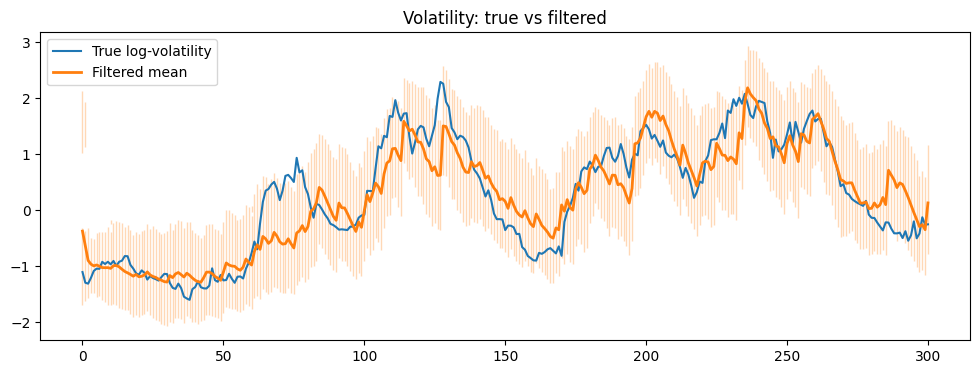

In [10]:
# Plot graph of true vs estimated log volatility
plt.figure(figsize=(12, 4))
plt.plot(h_true, label="True log-volatility")
plt.plot(h_mean_all, label="Filtered mean", linewidth=2)

# Loop over each time point and fill all intervals
for t in range(T):
    intervals = h_HDI_all[t]  # This should be a list of [low, high] pairs
    for low, high in intervals:
        plt.fill_between([t, t], [low, low], [high, high], color='C1', alpha=0.3)

plt.legend()
plt.title("Volatility: true vs filtered")
plt.show()


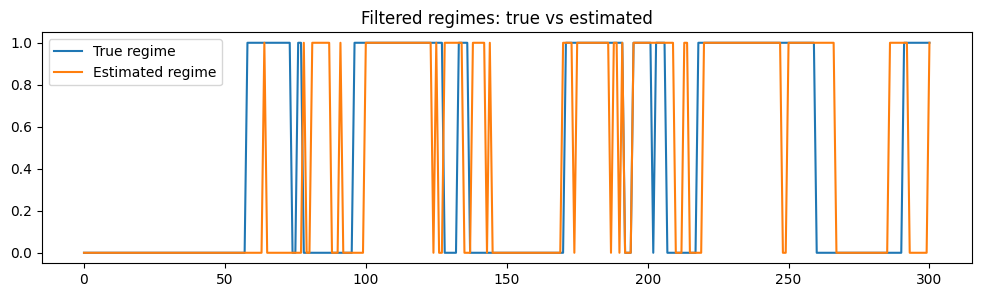

In [11]:
# Plot graph of true vs estimated regimes
plt.figure(figsize=(12, 3))
plt.plot(s_true, label="True regime")
plt.plot(s_median_all, label="Estimated regime")
plt.legend()
plt.title("Filtered regimes: true vs estimated")
plt.show()